In [11]:
!pip install -U scikeras scikit-learn scikeras tensorflow scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but yo

**Step 1. Import libraries**


In [1]:
# import libraries
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras import regularizers
from keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

**Step 2. Connect to google drive or load dataset**
There are two options to open up dataset


*   Direct load from google drive by mount colab with Google drive using from google.colab import drive
drive.mount('/content/drive')
*   Upload from local laptop



In [2]:
# //connect to google drive//
from google.colab import drive
drive.mount('/content/drive')
#// uplodaing data into google cola//
# from google.colab import files
# uploaded = files.upload()
# //Store and show the data//
df = pd.read_csv('/content/drive/MyDrive/GEE_irrigation/NLDAS_solar_weather_2023_Tcns.csv') # replace path
df # to print the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,hour,pa,ppt,swin,ta,Tcns
0,2023-04-01,11,91411.898438,0.0,0.000000,-1.130005,12.295064
1,2023-04-01,12,91441.000000,0.0,0.000000,-1.250000,14.768464
2,2023-04-01,13,91379.500000,0.0,76.650002,0.110016,16.930636
3,2023-04-02,11,90264.898438,0.0,0.000000,5.190002,18.265874
4,2023-04-02,12,90236.000000,0.0,0.000000,4.929993,19.180604
...,...,...,...,...,...,...,...
634,2023-10-29,12,92304.398438,0.0,0.000000,-2.850006,2.540060
635,2023-10-29,13,92319.000000,0.0,0.000000,-2.609985,4.047987
636,2023-10-30,11,92374.296875,0.0,0.000000,-7.679993,4.338116
637,2023-10-30,12,92360.101562,0.0,0.000000,-7.979980,6.978808


**Step 3. Prepare Data for Modeling**
- Selects key predictor variables from the NLDAS dataset:
  - `pa` → surface pressure  
  - `ppt` → precipitation  
  - `swin` → shortwave radiation  
  - `ta` → air temperature  
- Defines the target variable `y = Tcns` (observed canopy temperature).  
- Splits data into training and testing subsets using `train_test_split`:  
  - 70% for training,  
  - 30% for testing,  
  - `random_state=45` ensures reproducibility.  


In [3]:
# defining model independent (X) and dependent (y) values
X = df[['pa','ppt','swin','ta']]
y = df['Tcns']
print (X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 45)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

               pa  ppt       swin        ta
0    91411.898438  0.0   0.000000 -1.130005
1    91441.000000  0.0   0.000000 -1.250000
2    91379.500000  0.0  76.650002  0.110016
3    90264.898438  0.0   0.000000  5.190002
4    90236.000000  0.0   0.000000  4.929993
..            ...  ...        ...       ...
634  92304.398438  0.0   0.000000 -2.850006
635  92319.000000  0.0   0.000000 -2.609985
636  92374.296875  0.0   0.000000 -7.679993
637  92360.101562  0.0   0.000000 -7.979980
638  92341.296875  0.0   0.000000 -6.949982

[639 rows x 4 columns]


**Step 4. Train a Recurrent Neural Network (RNN)**

In this step we build and train a **Simple RNN** to predict canopy temperature (`Tcns`) from NLDAS predictors.  

- **Define model architecture (`rnn_model`)**  
   - `Sequential()` → builds a model where layers are added in sequence.  
   - `SimpleRNN(20, input_shape=(4,1), activation='relu')` → recurrent layer with 20 neurons, expecting input shaped as 4 features × 1 timestep.  
   - Three `Dense(10, activation='relu')` layers with L2 regularization → prevent overfitting by penalizing large weights.  
   - `Dense(1, activation='linear')` → output layer for regression (continuous values).  
   - Optimizer = **Adam** with learning rate 0.01.  
   - Loss = **MSE (Mean Squared Error)**, Metrics = MSE & MAE.  

- **Early stopping (`EarlyStopping`)**  
   - Stops training if validation loss does not improve for 10 epochs.  
   - `min_delta=0.001` means improvement smaller than this is ignored.  
   - `restore_best_weights=True` keeps the weights from the best epoch.  

- **Wrap with `KerasRegressor`**  
   - Allows sklearn-style training (`fit`, `predict`).  
   - Trains for 50 epochs with batch size = 32.  

- Fits the model on the training dataset (`X_train`, `y_train`).  
- Predicts values for the test dataset (`X_test`).  
- Evaluates performance with two metrics:  
  - **RMSE** (Root Mean Squared Error): measures prediction error magnitude,  
  - **R² (Coefficient of Determination):** proportion of variance explained.  

Reference reading:https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/


In [9]:
def rnn_model():
  model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
  model.add(SimpleRNN(20, input_shape=(4,1),activation='relu')) #simple recurrent layer, 10 neurons & process 50x1 sequences
  model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(l2=0.001)))
  model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(l2=0.001)))
  model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(l2=0.001)))
  model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='mse', optimizer= optimizer, metrics=['mse','mae'])
  return model

early_stopping = keras.callbacks.EarlyStopping(patience = 10, min_delta = 0.001, restore_best_weights = True)
rnn = KerasRegressor(model = rnn_model, batch_size = 32, epochs = 100, callbacks = [early_stopping],verbose = 1)

modelrnn = rnn
modelrnn.fit(X_train, y_train,validation_data=(X_test, y_test))
history = modelrnn.history_
y_predictrnn = modelrnn.predict(X_test)
print('RMSErnn:', np.sqrt(metrics.mean_squared_error(y_test,y_predictrnn)))
print('R-Squaredrnn: %.3f' % (metrics.r2_score(y_test,y_predictrnn)))

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 476.9725 - mae: 20.9996 - mse: 476.9418 - val_loss: 204.9765 - val_mae: 12.9431 - val_mse: 204.9446
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 185.3908 - mae: 10.3440 - mse: 185.3586 - val_loss: 75.0282 - val_mae: 7.2187 - val_mse: 74.9961
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 62.1649 - mae: 5.8958 - mse: 62.1323 - val_loss: 27.9599 - val_mae: 4.0435 - val_mse: 27.9264
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.2317 - mae: 3.1349 - mse: 18.1978 - val_loss: 18.1634 - val_mae: 3.1620 - val_mse: 18.1286
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.3648 - mae: 2.7805 - mse: 14.3299 - val_loss: 14.3616 - val_mae: 2.9017 - val_mse: 14.3265
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1886 - mae: 2.3450 - mse: 9.1536 - val_loss: 14.4464 - val_mae: 2.9978 - val_mse: 14.4116
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.7180 - mae: 2.4764 - ms

**Step 5. Visualize Training Performance**

After training the RNN, we want to inspect how the error evolved over epochs.  
- Extracts the **training and validation MSE history** from the `history` object.  
   - Uses `.get()` so it works whether the metric key is stored as `'mse'` or `'mean_squared_error'` (naming can differ by TensorFlow/Keras versions).  
   - Same for validation metrics (`'val_mse'` or `'val_mean_squared_error'`).  
- Plots the training vs. validation errors across epochs.  
- Labels the y-axis as **MSE**, even though we are plotting raw MSE values.  

Why this matters?
- If **training error decreases but validation error increases**, the model may be **overfitting**.  
- If both errors are flat and high, the model is **underfitting**.  
- Ideally, both training and validation errors decrease and stabilize at similar values.  
- Reference reading:https://www.geeksforgeeks.org/deep-learning/training-and-validation-loss-in-deep-learning/

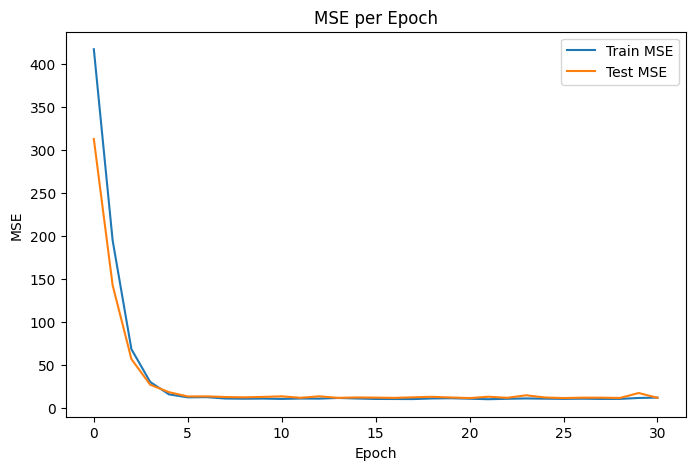

In [5]:
# If you didn’t add custom rmse, use sqrt of mse
train_mse = history.get('mse', history.get('mean_squared_error'))
val_mse   = history.get('val_mse', history.get('val_mean_squared_error'))


plt.figure(figsize=(8,5))
plt.plot(train_mse, label='Train MSE')
plt.plot(val_mse, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE per Epoch')
plt.legend()
plt.show()

**Step 6. Train and Evaluate Random Forest Model**

We now apply a **Random Forest Regressor** to predict Tcns (or another target variable) using the weather predictors.  


- Initializes a `RandomForestRegressor` with:
  - `n_estimators=50` → number of decision trees,  
  - `max_depth=10` → maximum depth of each tree (prevents overfitting),  
  - `random_state=42` → reproducibility,  
  - `n_jobs=-1` → use all available CPU cores.  
- Fits the model on the training dataset (`X_train`, `y_train`).  
- Predicts values for the test dataset (`X_test`).  
- Evaluates performance with two metrics:  
  - **RMSE** (Root Mean Squared Error): measures prediction error magnitude,  
  - **R² (Coefficient of Determination):** proportion of variance explained.  

In [6]:
rfmodel = RandomForestRegressor(n_estimators=50,max_depth=10,random_state=42, n_jobs=-1)
rfmodel.fit(X_train, y_train)
y_predictrf = rfmodel.predict(X_test)
print('RMSErf:', np.sqrt(metrics.mean_squared_error(y_test,y_predictrf)))
print('R-Squaredrf: %.3f' % (metrics.r2_score(y_test,y_predictrf)))

RMSErf: 3.478370121846864
R-Squaredrf: 0.719


**Step 7. Cross-Validation with RMSE (Random Forest & RNN)**

To make sure our models are not just fitting by chance, we perform **k-fold cross-validation** with **RMSE** as the evaluation metric.  

- Defines a helper function `modelmetrics_rmse(model, X, Y)`:
  - Uses `RepeatedKFold` (3 splits × 6 repeats = 18 folds total).  
  - Runs `cross_val_score` with **negative RMSE** scoring (sklearn convention).  
  - Returns the array of RMSE scores (converted back to positive).  

Cross-validation helps estimate the model’s **generalization performance** and highlights variability across folds (via standard deviation).  


In [7]:
def modelmetrics_rmse(model, X, Y):
    cv = RepeatedKFold(n_splits=3, n_repeats=6, random_state=1)
    scores = cross_val_score(
        model, X, Y,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        error_score='raise'
    )
    return -scores  # returns an array of RMSE values


rmse_scores_rf = modelmetrics_rmse(rfmodel, X, y)
print("RF Mean RMSE:", rmse_scores_rf.mean())
print("RF Std RMSE:", rmse_scores_rf.std())

rmse_scores_rnn= modelmetrics_rmse(modelrnn, X, y)
print("RNN Mean RMSE:", rmse_scores_rnn.mean())
print("RNN Std RMSE:", rmse_scores_rnn.std())

RF Mean RMSE: 3.1959735651363386
RF Std RMSE: 0.2134449251420188


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RNN Mean RMSE: 6.788206535980868
RNN Std RMSE: 1.180943626995898


**Step 8. Visualize Model Performance (Observed vs. Predicted)**

We now compare predictions from the **RNN** and **Random Forest (RF)** models against observed values using scatter plots.  

**What this does:**
- Creates a figure with **two subplots** (side by side).  
    - Left subplot (RNN)
    - Right subplot (RF)

- Points close to the 1:1 line indicate good performance.


Observed vs. predicted plots provide a **quick visual diagnostic** of model accuracy and bias.   


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3864560907.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_xlabel('Observed ($^\circ$C)')
/tmp/ipython-input-3864560907.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('Predicted ($^\circ$C)')
/tmp/ipython-input-3864560907.py:22: SyntaxWarning: invalid escape sequence '\c'
  ax[1].set_xlabel('Observed ($^\circ$C)')
/tmp/ipython-input-3864560907.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax[1].set_ylabel('Predicted ($^\circ$C)')


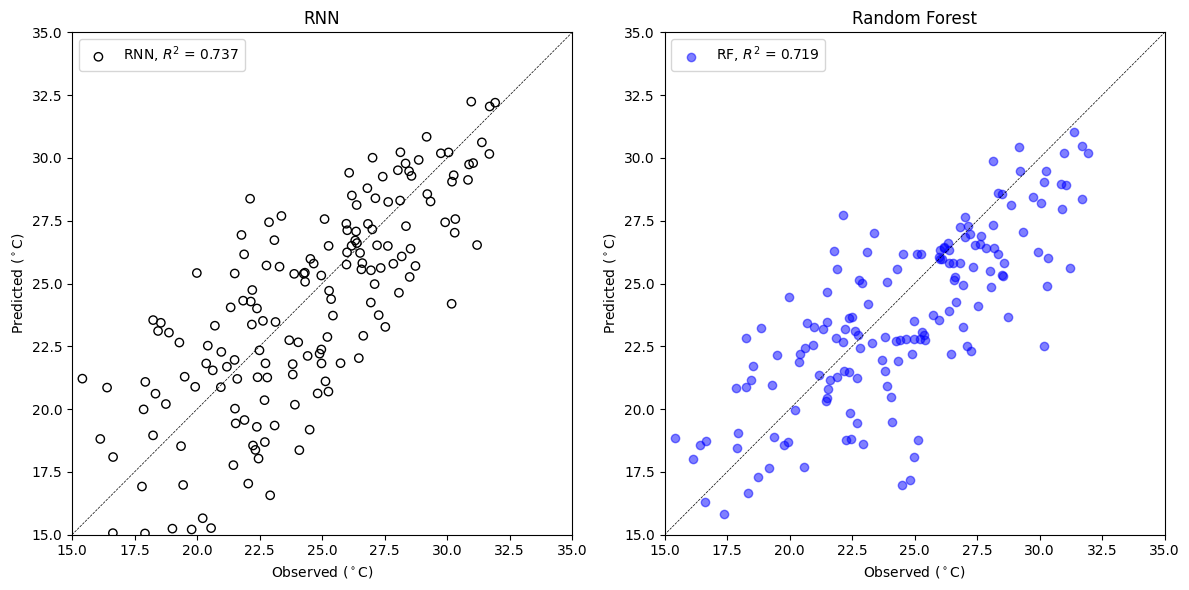

In [10]:
#subplots returns a Figure and an Axes object

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# --- RNN subplot ---
ax[0].scatter(y_test, y_predictrnn,
              edgecolor='black', facecolor='none',
              label=f'RNN, $R^2$ = {metrics.r2_score(y_test, y_predictrnn):.3f}')
ax[0].plot([15, 35], [15, 35], 'k--', lw=0.5)
ax[0].set_title("RNN")
ax[0].set_xlabel('Observed ($^\circ$C)')
ax[0].set_ylabel('Predicted ($^\circ$C)')
ax[0].set_xlim(15, 35); ax[0].set_ylim(15, 35) #Sets consistent axis ranges (15–35 °C) for fair comparison.
ax[0].legend()

# --- RF subplot ---
ax[1].scatter(y_test, y_predictrf,
              color='blue', alpha=0.5,
              label=f'RF, $R^2$ = {metrics.r2_score(y_test, y_predictrf):.3f}')
ax[1].plot([15, 35], [15, 35], 'k--', lw=0.5)
ax[1].set_title("Random Forest")
ax[1].set_xlabel('Observed ($^\circ$C)')
ax[1].set_ylabel('Predicted ($^\circ$C)')
ax[1].set_xlim(15, 35); ax[1].set_ylim(15, 35) #Sets consistent axis ranges (15–35 °C) for fair comparison.
ax[1].legend()

plt.tight_layout() #Uses `plt.tight_layout()` to avoid overlap.
plt.show()

# **Other Reference Readings:**
1. Hyperparameter tuning: https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/
2. RNN: https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92
3. rnn sample code: https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html
4. Random Forest:https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/
5. Why kfold CV: https://towardsdatascience.com/the-importance-of-k-fold-cross-validation-for-model-prediction-in-machine-learning-4709d3fed2ef
6. Real-time irrigation scheduling of maize using Degrees Above Non-Stressed (DANS) index: https://www.sciencedirect.com/science/article/pii/S0378377422005042
7. Weather data-centric prediction of maize non-stressed canopy temperature:https://link.springer.com/article/10.1007/s00271-023-00863-w